# A deeper dive into the Gauss-Levenberg-Marquardt (GLM) algorithm: weights and noise

The Gauss-Levenberg-Marquart (GLM) method is a gradient-based method used to search the objective function surface for its minimum value. It assumes that simulated values of observation targets vary continuously in response to changes in calibration-adjusted model parameters.  Two critical aspects of using ensemble-forms of GLM are how weights and observation noise are specified.  We will do this using the response surface of a simple 2-parameter form of the freyberg model

This notebook builds on the previous response-surface notebook - check it out for a discussion of the GLM lambda in the context of response surfaces...

### Admin
We have provided some pre-cooked PEST dataset files, wrapped around the modified Freyberg model. This is the same dataset introduced in the "freyberg_pest_setup" and "freyberg_k" notebooks. 

The functions in the next cell import required dependencies and prepare a folder for you. This folder contains the model files and a preliminary PEST setup. Run the cells, then inspect the new folder named "freyberg_mf6" which has been created in your tutorial directory. (Just press `shift+enter` to run the cells). 

In [3]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import shutil

# sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd
import response_surface as resurf

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

run_response_surfaces = False

Here we prep for the response surface runs:

In [4]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
# a dir to hold a copy of the org model files
tmp_d = os.path.join('freyberg_mf6')

if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)
# get executables
hbd.prep_bins(tmp_d)
# get dependency folders
hbd.prep_deps(tmp_d)
# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(tmp_d)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Dec 29 2021 09:30:50 with Intel(R) Fortran Intel(R) 64
   Compiler for applications running on Intel(R) 64, Version 19.1.3.301 Build
                                20200925_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the autho

### Reminder - the modified-Freyberg model
Just a quick reminder of what the model looks like and what we are doing. 

It is a one-layer model. A river runs north-south, represented with the SFR package (green cells in the figure). On the southern border there is a GHB (cyan cells). No-flow cells are shown in black. Pumping wells are shown with red cells. 

Time-series of measured heads are available at the locations marked with black X's. River flux is also measured at three locations (headwater, tailwater and gage; not displayed).

The simulation starts with a steady state stress period, followed by twelve transient stress periods. These represent the historic period, for which measured data are available.

A subsequent twelve transient stress periods representing a period in the future. Modelling is undertaken to assess selected forecasts during the simulated period.

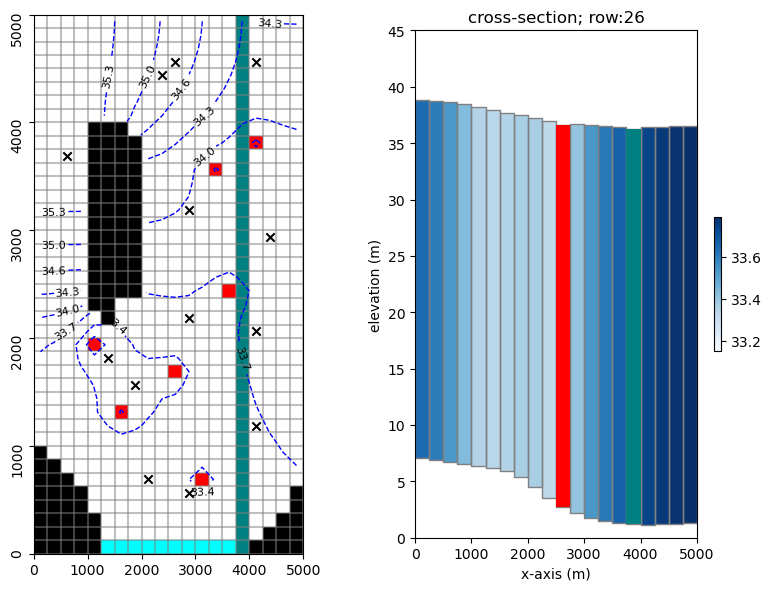

In [5]:
hbd.plot_freyberg(tmp_d)

### The PEST Control File

You may  wish to explore the `freyberg_mf6` folder which has been created in the tutorial directory. In it you will find a PEST control file named `freyberg.pst`.

Let's use `pyemu` to load the PEST control file and check some details. 

In [6]:
pst = pyemu.Pst(os.path.join(tmp_d, 'freyberg.pst'))
pst.par_names

['hk1', 'ne1', 'rch0', 'rch1']

In [7]:
par = pst.parameter_data
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,extra,dercom
parnme,,,,,,,,,,,
hk1,hk1,log,factor,5.00,0.050,500.00,hk,1.0,0.0,NaN,1.0
ne1,ne1,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,NaN,1.0
rch0,rch0,fixed,factor,1.00,0.500,2.00,rch0,1.0,0.0,NaN,1.0
rch1,rch1,fixed,factor,1.00,0.500,2.00,rch1,1.0,0.0,NaN,1.0


We shall explore the effect of having two adjustable parameters: `hk1` and `rch0`. As we saw in the previous response surface notebook, with just groundwater level observations, these two parameters are strongly correlated in the objective function. If we use only head observations for calibration we are unable to achive a unique solution. 

(We shall change `hk1` parameter bounds just to make visualization easier.)

In [8]:
par.loc['rch0', 'partrans'] = 'log'
par.loc['hk1', 'parlbnd'] = 1.5
par.loc['hk1', 'parubnd'] = 15

Re-write the control file:

In [9]:
pst.write(os.path.join(tmp_d, 'freyberg.pst'),version=2)

noptmax:0, npar_adj:2, nnz_obs:24


The `response_surface.py` file in the tutorial folder contains a few functions to run `PESTPP-SWP` and make plots. These run `PESTPP-SWP` a few hundred times for a combination of `hk1` and `rch0` values.

In [10]:
num_workers = 25

### Add Flux Observations

As we did in the previous response surface notebook, we know that if we add measurments of stream flow, we break that correlation, so let's do that here too:

In [11]:
pst = pyemu.Pst(os.path.join(tmp_d, 'freyberg.pst'))

In [12]:
# set weights to gage-1 observations during calibration period
obs = pst.observation_data
obs.loc[:,"observed"] = False

obs_times = obs.loc[~obs['gage-1'].isnull(), 'gage-1'].astype(float).values
calib_times = [str(i) for i in obs_times if i<4018.5]
obs.loc[obs['gage-1'].isin(calib_times), 'weight'] = 0.003 # we know from our own experiments this is a good, error-based value that creates a balanced objective function...
obs.loc[obs.weight > 0,"observed"] = True

Re-write the control file.

In [13]:
pst.write(os.path.join(tmp_d, 'freyberg.pst'),version=2)

noptmax:0, npar_adj:2, nnz_obs:36


Run PESTPP-SWP to calculate the response surface.

In [14]:
org_resp_d = "resp_weight1"
if run_response_surfaces:
    if os.path.exists(org_resp_d):
        shutil.rmtree(org_resp_d)
    shutil.copytree(tmp_d,org_resp_d)
    resurf.run_respsurf(par_names=['hk1','rch0'],num_workers=num_workers,port=4269,WORKING_DIR=org_resp_d)

And plot it up. As expected, we see the objective function surface funneling down to a single closed "region of attraction". We have achieved a unique solution.

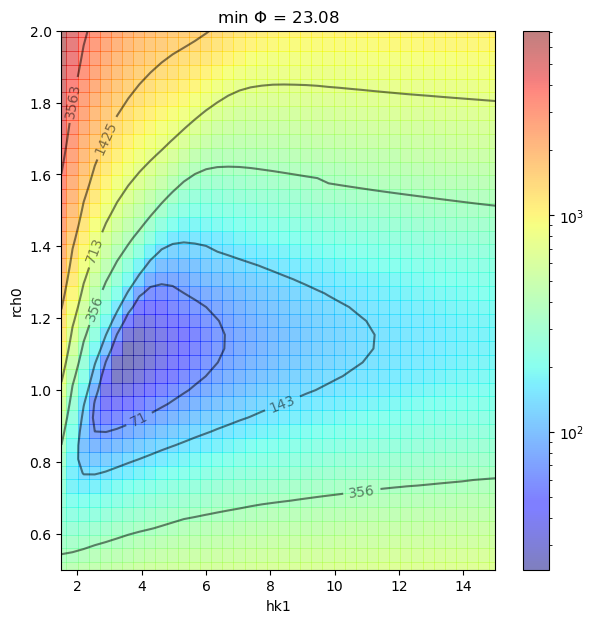

In [15]:
fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7),WORKING_DIR=org_resp_d) #maxresp=1e3,

### Understanding how weights change the response surface (and the result!)

A critical point in all of this: The weights assigned to the observations define the shape of the objective function (likelihood) function - note: herein, we refer to this as the response surface. The extreme example of this is adding observations.  But even just changing the weights between obserations also changes things.  To see this, lets the weights of the surface-water flux observations to a much higher proportion of the composite objective function (and while we are it, lets also make those surface-water flux observation weights a function of the observed value so that large flux values have lower weight):

In [16]:
obs = pst.observation_data
obs_times = obs.loc[~obs['gage-1'].isnull(), 'gage-1'].astype(float).values
calib_times = [str(i) for i in obs_times if i<4018.5]
ovals = obs.loc[obs['gage-1'].isin(calib_times), 'obsval']
obs.loc[obs['gage-1'].isin(calib_times), 'weight'] = 1./(ovals*0.01) #weight equals the inverse of 1% of the observed value
pst.write(os.path.join(tmp_d, 'freyberg.pst'),version=2)
mod_resp_d = "resp_weight2"
if run_response_surfaces:
    if os.path.exists(mod_resp_d):
        shutil.rmtree(mod_resp_d)
    shutil.copytree(tmp_d,mod_resp_d)
    resurf.run_respsurf(par_names=['hk1','rch0'],num_workers=num_workers,port=4269,WORKING_DIR=mod_resp_d)

noptmax:0, npar_adj:2, nnz_obs:36


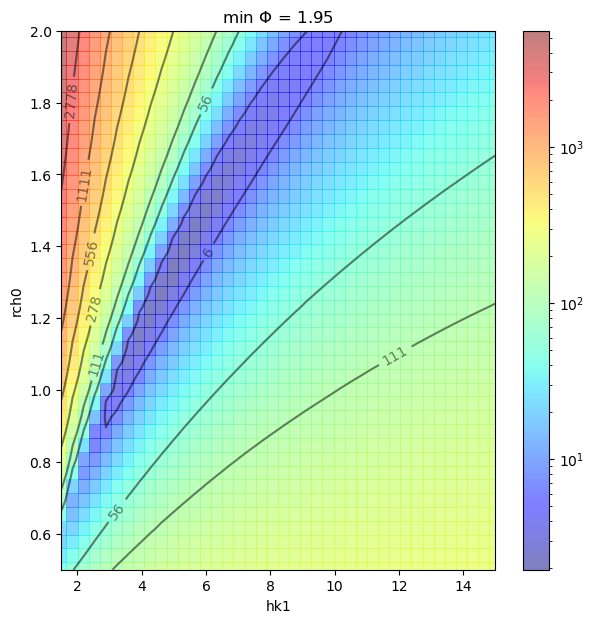

In [17]:
fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7),WORKING_DIR=mod_resp_d) #maxresp=1e3,

Thats a pretty shocking difference, especially when we consider that this is a simple 2-D (ie 2-parameter) problem.  Whats more, the goal of our data assimilation analyses is to navigate this surface to the (region around the) minimum.  Let's see how changing the weights changes the parameter posterior distribution

### Optional: choose your own adventure!

Here you can form your own objective function by changing weights and see how that changes the response surface and also (later on down the notebook) see how it effects PESTPP-IES and ultimately, posterior forecast uncertainty

In [18]:
# here is an example where the value of low sw flow obs is amplied:

# obs = pst.observation_data
# for grp in pst.nnz_obs_groups:
#     if "gage" not in grp:
#         continue
#     oobs = obs.loc[obs.obgnme==grp,:]
#     oobs = oobs.loc[oobs.observed==True,:]
#     mn = oobs.obsval.mean()
#     lower_names = oobs.loc[oobs.obsval<mn,"obsnme"]
#     assert len(lower_names) > 0
#     obs.loc[lower_names,"weight"] = 100

# pst.write(os.path.join(tmp_d, 'freyberg.pst'),version=2)
# mod_resp_d = "resp_weight2"

# if os.path.exists(mod_resp_d):
#    shutil.rmtree(mod_resp_d)
# shutil.copytree(tmp_d,mod_resp_d)
# resurf.run_respsurf(par_names=['hk1','rch0'],num_workers=num_workers,port=4269,WORKING_DIR=mod_resp_d)

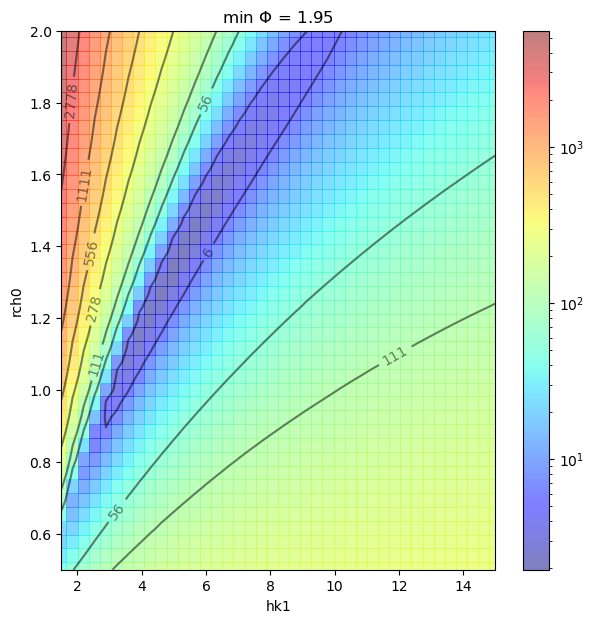

In [19]:
fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7),WORKING_DIR=mod_resp_d) #maxresp=1e3,

# Understanding how weights change results


This function just makes sure we are consistently using the same pest interface settings...

In [20]:
def prep_pst(t_d="template",noptmax=6):
    if os.path.exists(t_d):
        shutil.rmtree(t_d)
    shutil.copytree(org_d,t_d)
    # get executables
    hbd.prep_bins(t_d)
    # get dependency folders
    hbd.prep_deps(t_d)
    # run our convenience functions to prepare the PEST and model folder
    hbd.prep_pest(t_d)
    pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
    obs = pst.observation_data
    obs_times = obs.loc[~obs['gage-1'].isnull(), 'gage-1'].astype(float).values
    calib_times = [str(i) for i in obs_times if i<4018.5]
    obs.loc[obs['gage-1'].isin(calib_times), 'weight'] = 0.003
    #obs.loc[pst.nnz_obs_names,"standard_deviation"] = 10. / obs.loc[pst.nnz_obs_names,"weight"]
    
    par = pst.parameter_data
    par.loc['rch0', 'partrans'] = 'log'
    par.loc['hk1', 'parlbnd'] = 1.5
    par.loc['hk1', 'parubnd'] = 15
    
    par.loc[pst.adj_par_names,"partrans"] = "none"
    par.loc[pst.adj_par_names,"parval1"] = (par.loc[pst.adj_par_names,"parlbnd"] + par.loc[pst.adj_par_names,"parubnd"]) / 2.0
    
    pst.control_data.noptmax = noptmax
    pst.write(os.path.join(t_d,"freyberg.pst"),version=2)

Here is a nasty plotting function - just ignore it!

In [21]:
def plot_ies_and_resp_par_forecast_results(resp_d,ies_d):
    r_inp = pd.read_csv(os.path.join(resp_d,"freybergsweep_in.csv"),index_col=0)
    r_out = pd.read_csv(os.path.join(resp_d,"freybergsweep_out.csv"),index_col=1)
    r_out.loc[:,"likelihood"] = 1.0/r_out.phi.values**2
    phidf = pd.read_csv(os.path.join(ies_d,"freyberg.phi.actual.csv"))
    iiter = int(phidf.iteration.max())
    print("using iter",iiter)
    pe = pd.read_csv(os.path.join(ies_d,"freyberg.{0}.par.csv".format(iiter)),index_col=0)
    oe_pt = pd.read_csv(os.path.join(ies_d,"freyberg.{0}.obs.csv".format(iiter)),index_col=0)
    oe_pr = pd.read_csv(os.path.join(ies_d,"freyberg.0.obs.csv"),index_col=0)
    r_inp.loc[:,"phi"] = r_out.likelihood
    
    
    

    fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7),WORKING_DIR=resp_d) #maxresp=1e3,
    pes = []
    for i in range(iiter+1):
        fname = os.path.join(ies_d,"freyberg.{0}.par.csv".format(i))
        if not os.path.exists(fname):
            break
        pe = pd.read_csv(fname,index_col=0)    
        pes.append(pe)
    for real in pes[-1].index:
        xvals  = [pe.loc[real,"hk1"] for pe in pes]
        yvals  = [pe.loc[real,"rch0"] for pe in pes]
        ax.plot(xvals,yvals,marker=".",c="0.5",lw=0.5)
    xvals = pes[-1].loc[:,"hk1"].values
    yvals = pes[-1].loc[:,"rch0"].values
    ax.scatter(xvals,yvals,marker=".",c="b",zorder=10)
    plt.savefig('iesplot.pdf', dpi=500
    )
    plt.show()

    fig,axes = plt.subplots(2,1,figsize=(6,6))
    hk1 = r_inp.groupby("hk1").sum().loc[:,"phi"]
    rch0 = r_inp.groupby("rch0").sum().loc[:,"phi"]
    hk1_space = hk1.index[1] - hk1.index[0]
    rch0_space = rch0.index[1] - rch0.index[0]
    axes[0].bar(hk1.index,hk1.values,width=hk1_space,alpha=0.1,fc="0.5")
    axes[1].bar(rch0.index,rch0.values,width=rch0_space,alpha=0.1,fc="0.5")
    axt0 = plt.twinx(axes[0])
    axt0.hist(pe.loc[:,"hk1"].values,density=True,alpha=0.5,fc="b")
    axt1 = plt.twinx(axes[1])
    axt1.hist(pe.loc[:,"rch0"].values,density=True,alpha=0.5,fc="b")
    axes[0].set_title("hk1",loc="left")
    axes[1].set_title("rch0",loc="left")
    for ax in [axes[0],axes[1],axt0,axt1]:
        ax.set_yticks([])
    
    for forecast in pst.pestpp_options["forecasts"].split(","):
        fig,ax = plt.subplots(1,1,figsize=(6,3))
        #ax.hist(r_out.loc[:,forecast].values,weights=r_out.likelihood.values,alpha=0.5,fc="0.5",density=True)
        ax.hist(oe_pr.loc[:,forecast].values,alpha=0.5,fc="0.5",density=True)
        ax.hist(oe_pt.loc[:,forecast].values,alpha=0.5,fc="b",density=True)
        ax.set_yticks([])
        ax.set_title(forecast,loc="left")
        ylim = ax.get_ylim()
        #fval = pst.observation_data.loc[forecast,"obsval"]
        #ax.plot([fval,fval],ylim,"r-",lw=2)
    

First let's run PESTPP-IES using the same weights as the original response surface above:

In [22]:
t_d = "template"
prep_pst(t_d=t_d)
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
obs = pst.observation_data
pst.write(os.path.join(t_d,"freyberg.pst"),version=2)
m_d = "master_orgweight"
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg.pst",num_workers=num_workers,worker_root=".",master_dir=m_d)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Dec 29 2021 09:30:50 with Intel(R) Fortran Intel(R) 64
   Compiler for applications running on Intel(R) 64, Version 19.1.3.301 Build
                                20200925_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the autho

using iter 6


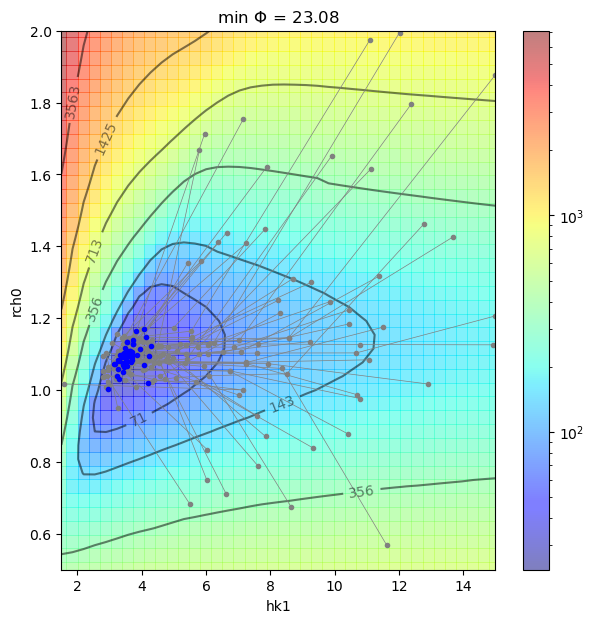

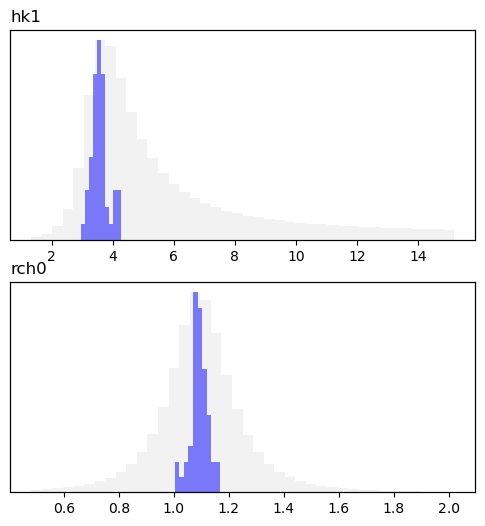

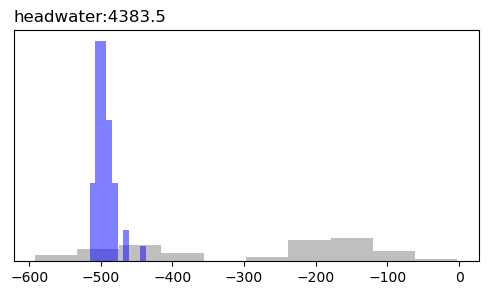

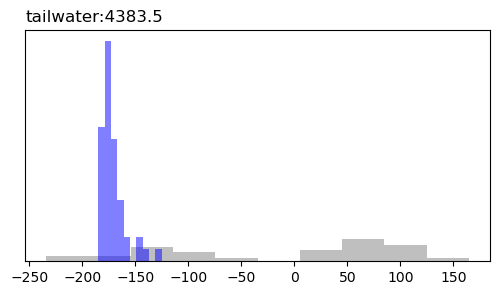

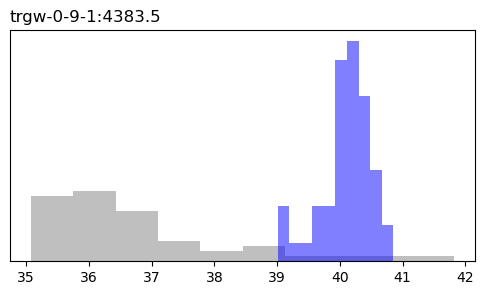

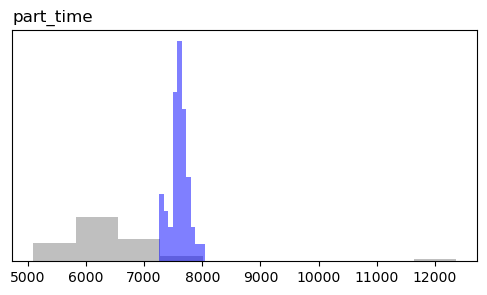

In [23]:
plot_ies_and_resp_par_forecast_results(org_resp_d,m_d)

GREAT SUCCESS!!!  Just what we wanted - each realization has a nice trajectory to the minimum of the misfit between simulated states and their observed counterparts.  Now, in the typical groundwater modeling approach, lets mess with this success and use the modified weights we used for the second response surface above:

In [24]:
prep_pst(t_d)
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
obs = pst.observation_data
#obs.loc[pst.nnz_obs_names,"standard_deviation"] = 1. / obs.loc[pst.nnz_obs_names,"weight"]
obs = pst.observation_data
obs_times = obs.loc[~obs['gage-1'].isnull(), 'gage-1'].astype(float).values
calib_times = [str(i) for i in obs_times if i<4018.5]
ovals = obs.loc[obs['gage-1'].isin(calib_times), 'obsval']
obs.loc[obs['gage-1'].isin(calib_times), 'weight'] = 1./(ovals*0.01)
pst.write(os.path.join(t_d,"freyberg.pst"),version=2)
m_d = "master_largerweight"
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg.pst",num_workers=num_workers,worker_root=".",master_dir=m_d)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Dec 29 2021 09:30:50 with Intel(R) Fortran Intel(R) 64
   Compiler for applications running on Intel(R) 64, Version 19.1.3.301 Build
                                20200925_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the autho

using iter 6


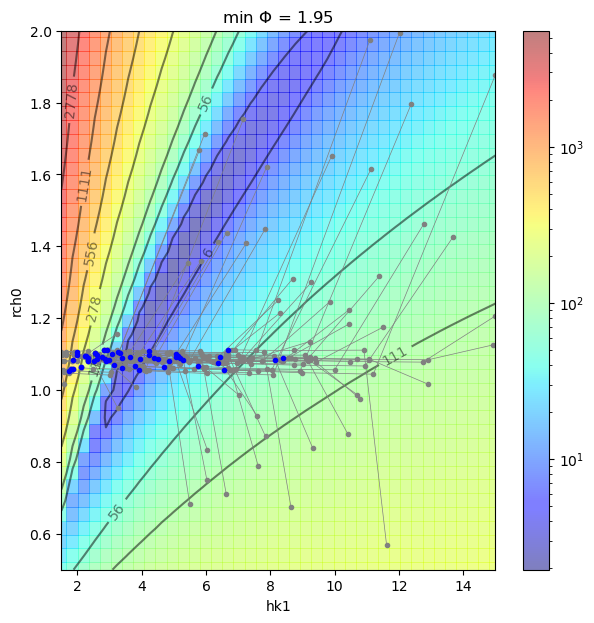

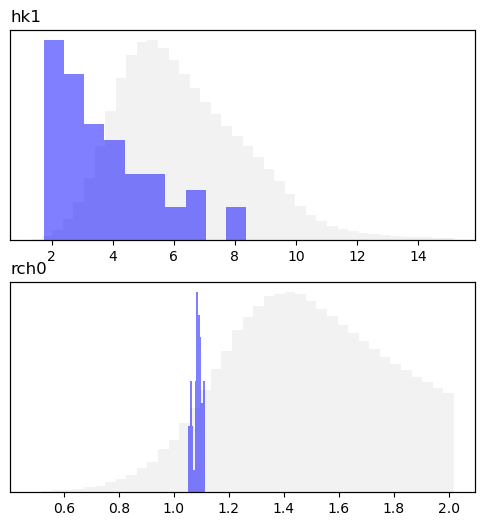

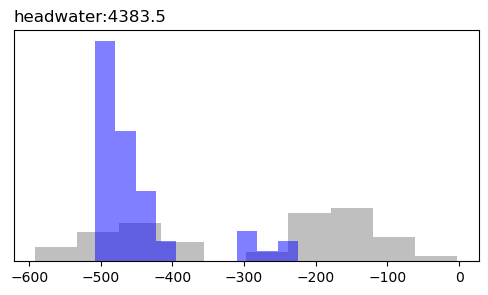

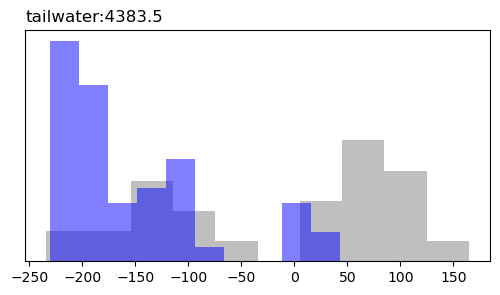

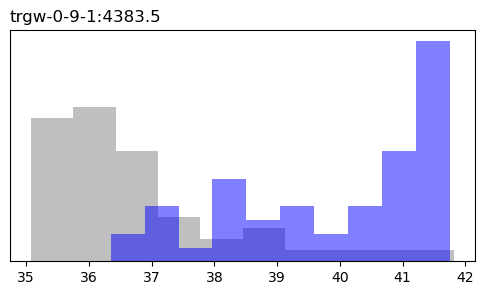

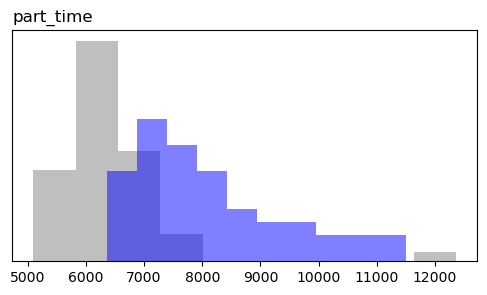

In [25]:
plot_ies_and_resp_par_forecast_results(mod_resp_d,m_d)

Ouch - thats much uglier.  We can see that the trajectory across the response surface suffers from the nonlinearity as the realizations navigate to the trough of dispair, and then just make a sharp change in direction.  #notgood.  Just for fun let's see if the PESTPP-IES multimodal solution process can help here - we will use basically all realizations in the ensemble and simply use the multimodal process to give us a better gradient approximation for each individual realization:

In [26]:
pst.pestpp_options["ies_multimodal_alpha"] = 0.99        
pst.write(os.path.join(t_d,"freyberg.pst"),version=2)
m_d = "master_largerweight_mm"
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg.pst",num_workers=num_workers,worker_root=".",master_dir=m_d)

noptmax:6, npar_adj:2, nnz_obs:36


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.6
binary compiled on Aug 15 2023 at 16:48:53

started at 11/21/23 15:45:23
...processing command line: ' ./pestpp-ies freyberg.pst /h :4004'
...using panther run manager in master mode using port 4004

using control file: "freyberg.pst"
in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_06_glm_response_surface/master_largerweight_mm"
on host: "IGSACB116LHMNFI"

processing control file freyberg.pst


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'


KeyboardInterrupt: 

In [ ]:
plot_ies_and_resp_par_forecast_results(mod_resp_d,m_d)

### Understanding how noise effects posterior results

Results so far, the noise realizations used in the assimilation process were derived from the assumption that the noise standard deviation was the inverse of the assigned weights.  This is not an ideal situation and in real-world practice (where models are imperfect simulators), we should always seperate the weights and noise.  This can be done in many, many ways.  Herein, we will do this by supplying a `standard_deviation` column in the observation data.  For our first experiement, lets assume the noise standard deviation for groundwater levels is 5.0 and the noise standard deviation for sw flow is 33% of the flow value:

In [27]:
t_d = "template"
prep_pst(t_d)
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
obs = pst.observation_data
hnames = [n for n in pst.nnz_obs_names if "trgw" in n]
gnames = [n for n in pst.nnz_obs_names if "gage" in n]
assert len(hnames) + len(gnames) == pst.nnz_obs
obs.loc[hnames,"standard_deviation"] = 5.0
obs.loc[gnames,"standard_deviation"] = obs.loc[gnames,"obsval"] * 0.33
pst.write(os.path.join(t_d,"freyberg.pst"),version=2)
m_d = "master_bignoise"
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg.pst",num_workers=num_workers,worker_root=".",master_dir=m_d)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Dec 29 2021 09:30:50 with Intel(R) Fortran Intel(R) 64
   Compiler for applications running on Intel(R) 64, Version 19.1.3.301 Build
                                20200925_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the autho

using iter 6


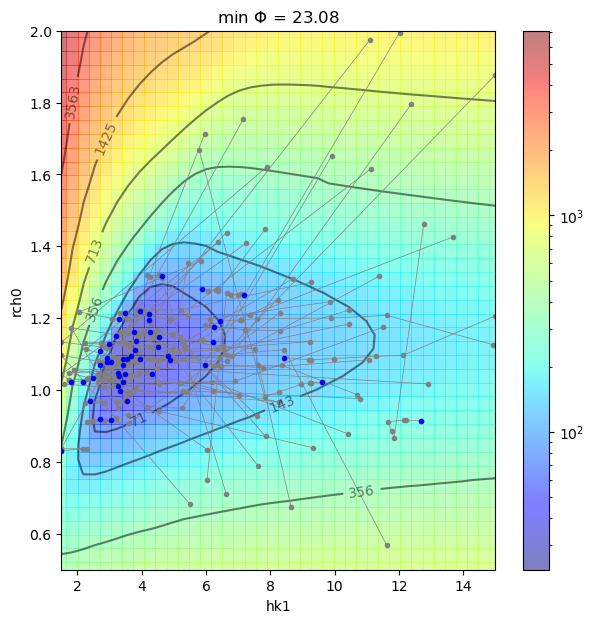

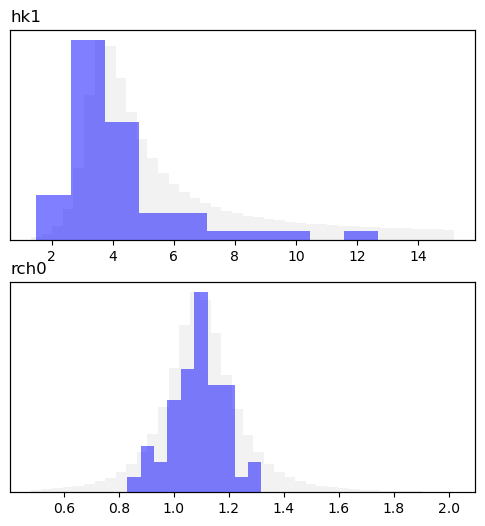

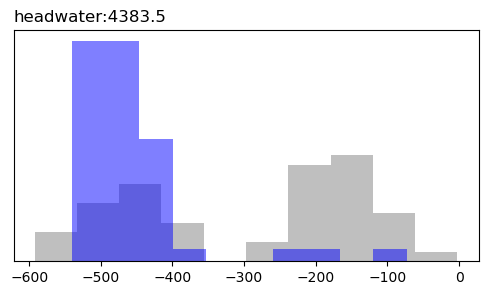

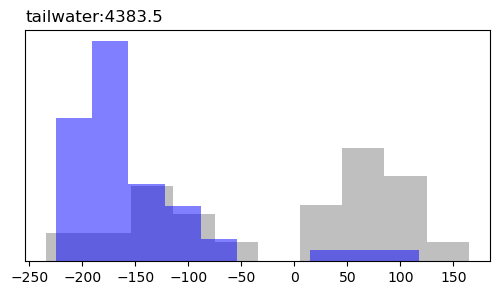

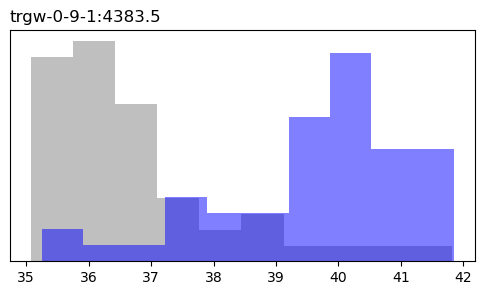

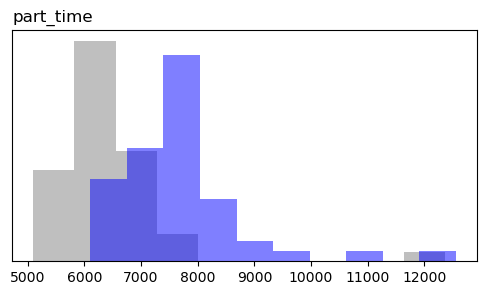

In [28]:
plot_ies_and_resp_par_forecast_results(org_resp_d,m_d)

Yowza!  Thats a very different result! This spread in the posterior is a direct result of using noisy (aka "perturbed", aka "stochastic") observation values - remember each parameter realization is paired up with a set of these noise obs, so each parameter realization is aiming for different objective function minimum - more noise means bigger differences in realization objective function minima. This is how we explicitly include observation noise in the posterior results...

### With multimodal solution

Lets see how the multi-modal solution copes with the high levels of noise:

In [ ]:
t_d = "template"
prep_pst(t_d)
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
obs = pst.observation_data
hnames = [n for n in pst.nnz_obs_names if "trgw" in n]
gnames = [n for n in pst.nnz_obs_names if "gage" in n]
assert len(hnames) + len(gnames) == pst.nnz_obs
obs.loc[hnames,"standard_deviation"] = 5.0
obs.loc[gnames,"standard_deviation"] = obs.loc[gnames,"obsval"] * 0.33
pst.pestpp_options["ies_multimodal_alpha"] = 0.99
pst.write(os.path.join(t_d,"freyberg.pst"),version=2)
m_d = "master_bignoise_mm"
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg.pst",num_workers=num_workers,worker_root=".",master_dir=m_d)

In [ ]:
plot_ies_and_resp_par_forecast_results(org_resp_d,m_d)

### Less noisy

Just to round-out our analyses, let's get a middle-ground noisy result for comparison:

In [29]:
t_d = "template"
prep_pst(t_d)
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
obs = pst.observation_data
obs = pst.observation_data
hnames = [n for n in pst.nnz_obs_names if "trgw" in n]
gnames = [n for n in pst.nnz_obs_names if "gage" in n]
assert len(hnames) + len(gnames) == pst.nnz_obs
obs.loc[hnames,"standard_deviation"] = 3.0
obs.loc[gnames,"standard_deviation"] = obs.loc[gnames,"obsval"] * 0.25
pst.write(os.path.join(t_d,"freyberg.pst"),version=2)
m_d = "master_mediumnoise"
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg.pst",num_workers=num_workers,worker_root=".",master_dir=m_d)


                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Dec 29 2021 09:30:50 with Intel(R) Fortran Intel(R) 64
   Compiler for applications running on Intel(R) 64, Version 19.1.3.301 Build
                                20200925_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the autho

using iter 6


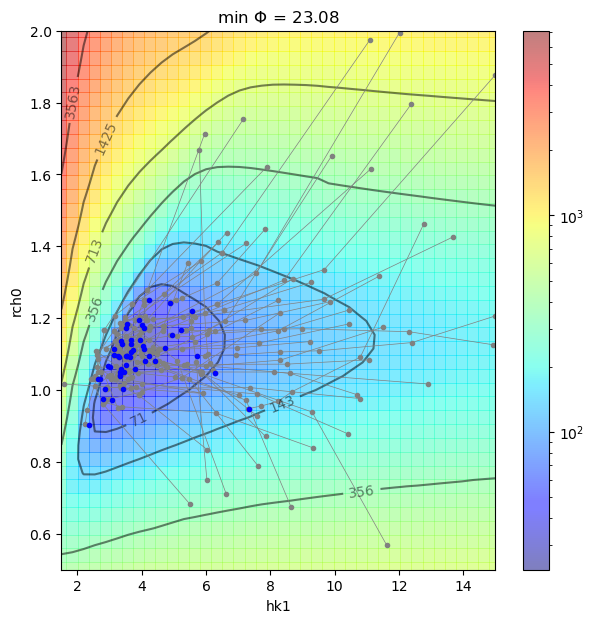

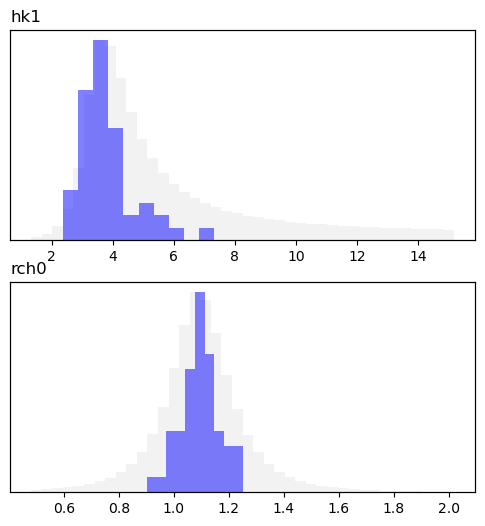

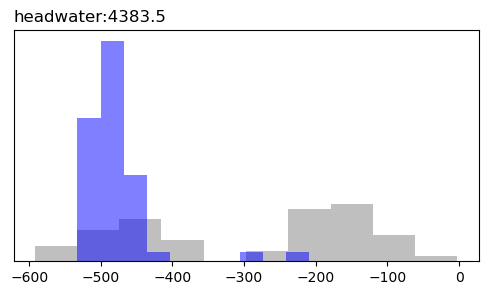

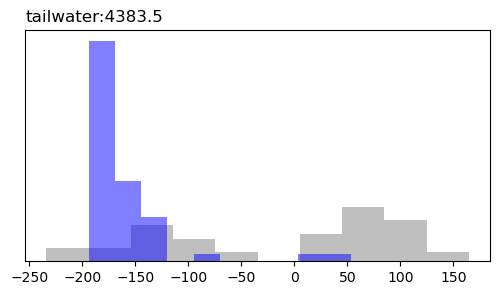

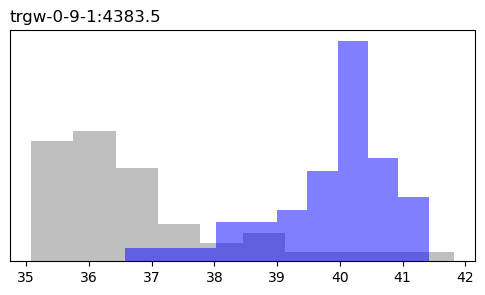

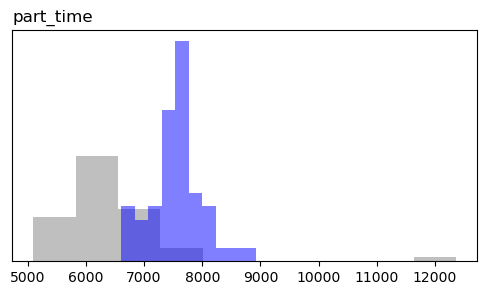

In [30]:
plot_ies_and_resp_par_forecast_results(org_resp_d,m_d)

Ok now it should be clear - the noise is controlling the posterior variance of both parameters - this is not unexpected in a well-posed inverse problem as both parameters are being strongly conditioned by all the observations.  But in all cases, thought must be put into noise, and, at the very least, weights and noise should be specified explicitly and separately, especially in situations where weights are being adjusted to balance contributions to the objective function.  

## Bonus material: understanding how ensemble methods cope with non-uniqueness

A major issue in applied groundwater modeling is the inability to uniquely identify all of the uncertain model inputs with the available data.  Using subspace concepts, we would refer to this a large null space and this source of uncertainty is a major contributor to posterior forecast uncertainty.  We saw this in pictures in the original response surface notebook when we graphed the response surface between `hk` and `recharge` when only groundwater level data were being assimilated.  Lets see that again:

In [ ]:
pst = pyemu.Pst(os.path.join(tmp_d,"freyberg.pst"))
obs = pst.observation_data
for grp in pst.nnz_obs_groups:
    if "gage" not in grp:
        continue
    obs.loc[obs.obgnme==grp,"weight"] = 0.0

pst.write(os.path.join(tmp_d, 'freyberg.pst'),version=2)
mod2_resp_d = "resp_weight2"

if os.path.exists(mod2_resp_d):
   shutil.rmtree(mod2_resp_d)
shutil.copytree(tmp_d,mod2_resp_d)
resurf.run_respsurf(par_names=['hk1','rch0'],num_workers=num_workers,port=4269,WORKING_DIR=mod2_resp_d)

In [ ]:
fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7),WORKING_DIR=mod2_resp_d) #maxresp=1e3,

There is that trough of dispair where combinations of HK and recharge yield simulated groundwater levels that more-or-less reproduce observed groundwater levels.  Lets see how the ensemble smoother copes with this situation:

In [ ]:
t_d = "template"
prep_pst(t_d)
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
obs = pst.observation_data
gnames = [n for n in pst.nnz_obs_names if "gage" in n]
obs.loc[gnames,"weight"] = 0.0
pst.write(os.path.join(t_d,"freyberg.pst"),version=2)
m_d = "master_nonunique"
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg.pst",num_workers=num_workers,worker_root=".",master_dir=m_d)

In [ ]:
plot_ies_and_resp_par_forecast_results(mod2_resp_d,m_d)

Is that what you expected to happen?  Its what we want to happen...The posterior parameter ensemble effectively represents/captures the non-uniqueness, as seen in the parameter histogram plots - the main thing we "learned" by assimilating the groundwater levels is that HK shouldn't be larger than around 10 m/d and that recharge shouldnt be much lower than about 0.9 m/d. Other than that, there are a wide range of HK-recharge combinations that yield a reasonble fit to the observed groundwater levels.  Still, even this modest parameter conditioning has reduced uncetainty for some forecasts as shown in the histogram plots. 

## Double bonus: experimenting with a realization-local upgrade solution for a highly non-unique inverse problem

one more time from the top: just for fun, let's run the the multimodal solver on this highly non-unique inverse problem.  Briefly, the multi-modal solver solves the Gauss-Newton upgrade equation for each realization (one by one) and treats each realization as the center of it gradient approximation, rather than using a global mean gradient approximation that is shared across all realizations.  

Before running this experiment, try to visualize what you think the individual realization trajectories should look (remembering what the last experiment looked like, what lambda does to the solution trajectory, and how the multimodal solve forms a unique gradient estimate for each realization).  Got it?  Good...

In [ ]:
t_d = "template"
prep_pst(t_d)
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
obs = pst.observation_data
gnames = [n for n in pst.nnz_obs_names if "gage" in n]
obs.loc[gnames,"weight"] = 0.0
pst.pestpp_options["ies_multimodal_alpha"] = 0.99
pst.write(os.path.join(t_d,"freyberg.pst"),version=2)
m_d = "master_nonunique_mm"
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg.pst",num_workers=num_workers,worker_root=".",master_dir=m_d)

In [ ]:
plot_ies_and_resp_par_forecast_results(mod2_resp_d,m_d)

Is that what you were expecting?  TBH this is not what I was expecting the first time I ran this experiment - its a little counter-intuitive.  The key piece is to remember that a small lambda value is a more Newton-type solution that can cut across the gradient of the surface, and this, when combined with a more representative local gradient approximation for each realization, allows many realizations to "funnel" in toward the region of objective function minimum.  If you compare these trajectories to the previous experiment, you can see the value of the realization-local gradient approximation - in the previous experiment, all realizations in the lower right quadrant of parameter space essentially moved in the same trajectory (to the upper left), which is the optimal upgrade direction of the ensemble mean.  Whew! 